In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# reading all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [106]:
# build the dataset:

block_size = 3 # How many characters we take as an input to predict the next character. 

X, Y = [], []

for w in words: 
    # print(w)
    context = [0]* block_size # => it will give [0, 0, 0]
    
    for ch in w + '.':
        ix = stoi[ch]
        # print(ch)
        X.append(context) # the first will be [[0,0,0]] as context is [0,0,0] and X is [] when this loop is initiating
        # print(X)
        Y.append(ix)
        # print(Y)
        # print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] #crop and append
        # print(context)

        
X = torch.tensor(X)
Y = torch.tensor(Y)


In [107]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [60]:
C = torch.randn((27,2))
# C[5]
# for one individual number. For all of them, we can just use C[X]

C[X].shape

torch.Size([32, 3, 2])

In [22]:
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C # another way of doing it

torch.Size([27])

In [61]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [62]:
W1 = torch.randn((6,100)) # 6 because 3*2 as we have 3.2 sized shape at the end. 100 is variable. 
b1 = torch.randn(100)

In [63]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 1, :]], 1).shape
torch.cat(torch.unbind(emb, 1), 1).shape
# or we can also use emb.view(32,6)

torch.Size([32, 6])

In [64]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)

In [65]:
h.shape

torch.Size([32, 100])

In [66]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [67]:
logits = h @ W2 + b2

In [68]:
logits.shape

torch.Size([32, 27])

In [69]:
counts = logits.exp()

In [70]:
probs = counts/counts.sum(1, keepdim=True)

In [71]:
probs.shape

torch.Size([32, 27])

In [72]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [73]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [74]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(14.3933)

In [220]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words: 
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y
    
import random
random.seed(32)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int (0.9 * len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [221]:
# Rewriting everything now with defined structure
print(X.shape, Y.shape)
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g) # first index will be 2*3(changed it to 10*3), (2) for the C and 3 for the vector length [0,0,0] one, 
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2]


torch.Size([228146, 3]) torch.Size([228146])


In [222]:
sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [223]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [230]:
lri = []
lossi = []
stepi = []
for i in range(30000):
    # construct a minibatch
    ix = torch.randint(0,Xtr.shape[0], (32,)) # this will create a random minibatch of 32
    
    
    # forward pass
    emb = C[Xtr[[ix]]] # shape  = (32, 3 , 2)
    b1.shape
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 makes it determine what will be, in this case, 32. We have it 6 as W1 is 6 and emb is 32, 3, 2, so we make it 32, 6 by the view method
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # probs = counts/counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(32), Y].log().mean()
    # the above function is basically cross entryopy function
    loss = F.cross_entropy(logits, Ytr[ix])

    #backward pass 
    for p in parameters: 
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    for p in parameters: 
        p.data += -0.001 * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

1.9378345012664795


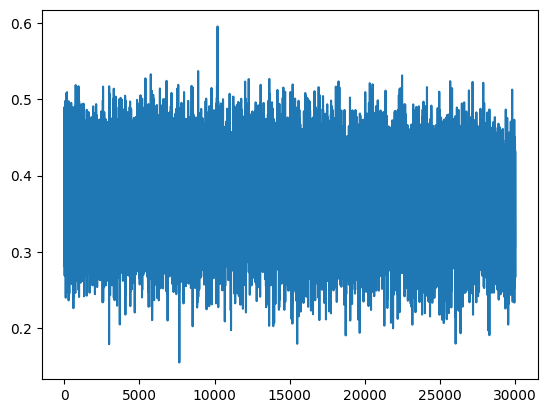

In [226]:
plt.plot(stepi, lossi)

In [231]:
emb = C[Xte] # shape  = (32, 3 , 2)
b1.shape
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 makes it determine what will be, in this case, 32. We have it 6 as W1 is 6 and emb is 32, 3, 2, so we make it 32, 6 by the view method
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1775, grad_fn=<NllLossBackward0>)

In [232]:
emb = C[Xdev] # shape  = (32, 3 , 2)
b1.shape
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # -1 makes it determine what will be, in this case, 32. We have it 6 as W1 is 6 and emb is 32, 3, 2, so we make it 32, 6 by the view method
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1817, grad_fn=<NllLossBackward0>)

In [ ]:
# train, dev/validation, test: 80:10:10

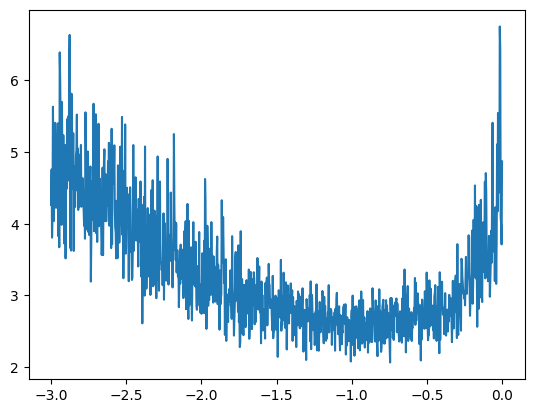

In [140]:
plt.plot(lri, lossi)

In [233]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs , num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
        
    print(''.join(itos[i] for i in out))

carmah.
ambrilli.
kimir.
rehty.
salaysa.
jazon.
nadelynn.
jareei.
neriana.
chaiir.
kaleigh.
ham.
joce.
quint.
shoulea.
jadbi.
wajero.
dearysix.
kae.
pirraylen.
